# 08 - log AB analysis

**Objectives**
* **!!! log transformed AB plaque index !!!**
* perform regressions per level1 region on ROIx1 plaque proximity index
* train GBM / other regressors per stratum: `CX+KI->pp`, `BS+KI->pp`, etc..

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import itertools
from numpy import ma  # masked array

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from boruta import BorutaPy

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, ShuffleSplit
from sklearn.metrics import confusion_matrix

import lime 
from lime.lime_tabular import LimeTabularExplainer

import sklearn.datasets
from lime.lime_tabular import LimeTabularExplainer

sns.set(style="whitegrid")

* Gradient Boosting early stop monitor - let's put this here up front as we use it frequently..

In [2]:
class EarlyStopMonitor:

    def __init__(self, window_length=25):
        self.window_length = window_length

    def window_boundaries(self, current_round):        
        lo = max(0, current_round - self.window_length + 1)
        hi = current_round + 1

        return lo, hi

    def __call__(self, current_round, regressor, _):        
        if current_round >= self.window_length - 1:
            lo, hi = self.window_boundaries(current_round)
            
            do_stop = np.mean(regressor.oob_improvement_[lo: hi]) < 0
            
            if do_stop:
                print('stopped after rounds: {}'.format(current_round))
            
            return do_stop
        else:
            return False

---

## Load the data

In [3]:
wd = '/media/tmo/data/work/datasets/02_ST'

logcpm_path = wd + '/ashley_21.03.2018/logcpm_merge_20180212.pickle'
meta_path = wd + '/meta/meta.parquet'

In [4]:
%%time
meta_df = pd.read_parquet(meta_path)

CPU times: user 184 ms, sys: 225 ms, total: 409 ms
Wall time: 276 ms


In [5]:
%%time
logcpm_df = pickle.load(open(logcpm_path, "rb"))

logcpm_df.index.name = 'spot_UID'
logcpm_df.reset_index(inplace=True)
logcpm_df.rename(columns={'sampleID': 'slide_ID'}, inplace=True)

CPU times: user 15.4 s, sys: 7.91 s, total: 23.3 s
Wall time: 23.4 s


In [6]:
st_df = logcpm_df.merge(meta_df, how='inner', on=['spot_UID', 'slide_ID'])

In [7]:
st_df['slide_ID'] = st_df['slide_ID'].astype('category', copy=False)
st_df['GT']       = st_df['GT'].astype('category', copy=False)
st_df['age']      = st_df['age'].astype('category', copy=False)
st_df['age_GT']   = st_df['age_GT'].astype('category', copy=False)

In [8]:
n_genes = 46454
gene_columns = st_df.columns[1:n_genes+1]

* merge with satellite tables

In [9]:
region_levels_df = pd.read_csv('region_levels.csv', sep=',', keep_default_na=False)

In [10]:
final_meta_df = pd.read_csv('final_metadata_scores.tsv', sep='\t', index_col=0)
final_meta_df.index.name = 'spot_UID'
final_meta_df.reset_index(inplace=True)
final_meta_df = final_meta_df[final_meta_df['AB'].notna()][['spot_UID', 'AB']]

### Log transform AB index
* the AB index is very skewed, this is not ideal for ML algorithm to regress upon
* use a masked array to compute natural log of AB index

cfr. **Jaak Simm**:
> if it is not transformed, the skewness will result in the fact that larger (absolute) deviations will be focused by the model
so lot of focus will be put into these high end values

In [11]:
final_meta_df['log_AB'] = ma.log(final_meta_df['AB'].as_matrix())

* let's check the distributions after log transform
* much nicer (Gaussian-like)
* there is some bimodality going on (could be batch effect, to investigate)

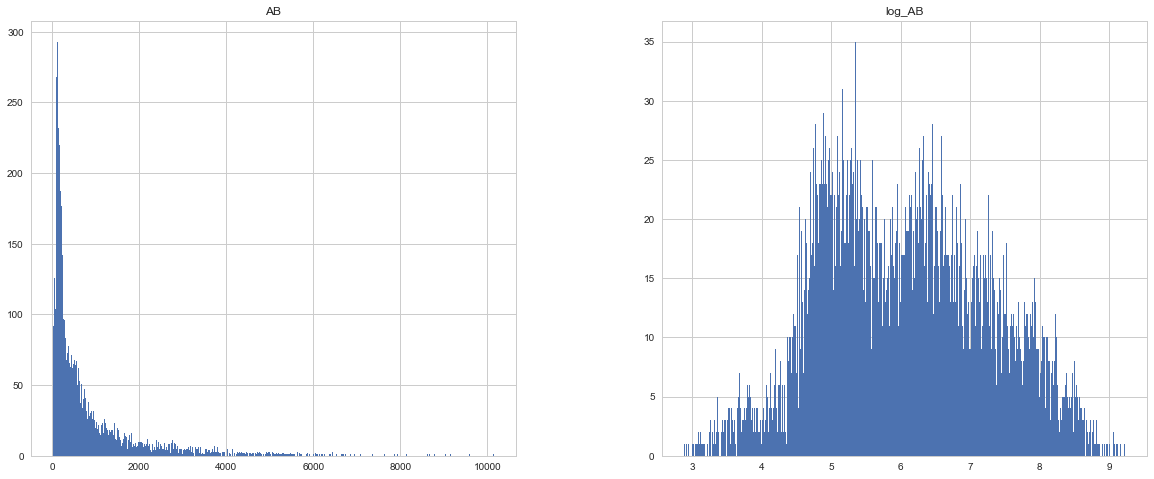

In [12]:
final_meta_df[final_meta_df['log_AB'] > 0][['AB', 'log_AB']].hist(bins=500, figsize=(20, 8))
plt.show()

In [13]:
full_df = st_df \
    .merge(region_levels_df, on='Region_predict') \
    .merge(final_meta_df, on='spot_UID')

In [14]:
expression_df = full_df[gene_columns]

In [15]:
expression_df.head()

,-343C11.2,00R_AC107638.2,0610005C13Rik,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,...,n-R5s90,n-R5s92,n-R5s93,n-R5s94,n-R5s95,n-R5s96,n-R5s97,n-R5s98,n-TSaga9,n-TStga1
0,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,4.984943,2.982974,2.982974,2.982974,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974
1,2.982974,2.982974,2.982974,2.982974,6.827059,5.924174,2.982974,2.982974,2.982974,2.982974,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974
2,2.982974,2.982974,2.982974,2.982974,2.982974,5.609164,2.982974,2.982974,5.609164,2.982974,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974
3,2.982974,2.982974,2.982974,2.982974,7.661385,2.982974,2.982974,2.982974,5.157746,5.157746,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974
4,2.982974,2.982974,2.982974,2.982974,6.738947,6.738947,2.982974,2.982974,2.982974,7.432553,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974


In [16]:
log_AB_df = full_df[['log_AB']]

In [18]:
# assert expression_df.shape == (10327, 46454) 
assert expression_df.shape == (10324, 46454)  # 3 less = damaged spots

---

## Boruta feature selection
* recompute the boruta feature selection step, regrssion onto the **log_AB** values.
* Boruta feature selection uses a RF regressor
* TODO: check out [RFE](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

Using boruta, features compete against scrambled versions of themeselves in order to determine which variables display predictive power towards the target variable. One can consider this step as a coarse grained features selection step.

In [19]:
boruta_genes_log_AB_path = '08_results/boruta_genes_log_AB.tsv'

* perform the Boruta feature selection on **log_AB**
* guess: we'll get more features 
* A: yep.. from 155 to ~1100
* this result is more in correspondence with boruta classification on the GT feature, which also returns 1000+ candidate features

In [20]:
boruta_genes = list(pd.read_csv(boruta_genes_log_AB_path, sep='\t', header=None)[0])

In [ ]:
# %%time
# boruta_selector = do_boruta()

In [58]:
# boruta_genes = gene_columns[boruta_selector.support_]

In [59]:
# pd.DataFrame(boruta_genes).to_csv(boruta_genes_log_AB_path, sep='\t', header=None, index=None)

* read from file

In [21]:
boruta_genes = list(pd.read_csv(boruta_genes_log_AB_path, sep='\t', header=None)[0])

In [22]:
len(boruta_genes)

1108

---

# Spots by region and genotype

* Sets of spots per Level_01 region
* Region: CX, BS, HP, NA
* Genotype: WT, KI

In [24]:
level_01_regions = region_levels_df.Level_01.unique()
level_01_regions

array(['CX', 'NA', 'BS', 'HP'], dtype=object)

In [25]:
KI_region_sets = {}
WT_region_sets = {}
KI_WT_region_sets = {}

for level_01 in level_01_regions:
    KI_region_sets[level_01]    = full_df[(full_df['Level_01'] == level_01) & (full_df['GT'] == 'KI')]    
    WT_region_sets[level_01]    = full_df[(full_df['Level_01'] == level_01) & (full_df['GT'] == 'WT')]    
    KI_WT_region_sets[level_01] = full_df[(full_df['Level_01'] == level_01)]

In [26]:
[(a, len(b)) for a,b in KI_region_sets.items()]

[('HP', 753), ('NA', 849), ('CX', 1888), ('BS', 1516)]

In [27]:
[(a, len(b)) for a,b in WT_region_sets.items()]

[('HP', 791), ('NA', 802), ('CX', 2213), ('BS', 1512)]

In [28]:
[(a, len(b)) for a,b in KI_WT_region_sets.items()]

[('HP', 1544), ('NA', 1651), ('CX', 4101), ('BS', 3028)]

---

# **-=[CX]=-**

In [29]:
CX_KI_WT_boruta = KI_WT_region_sets['CX'][boruta_genes]
CX_KI_WT_log_AB = KI_WT_region_sets['CX']['log_AB']
CX_GT           = KI_WT_region_sets['CX']['GT']

In [30]:
splitter = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_idx, test_idx = list(splitter.split(CX_KI_WT_boruta, CX_KI_WT_log_AB, groups=CX_GT))[0]

In [31]:
CX_KI_WT_boruta_train = CX_KI_WT_boruta.iloc[train_idx]
CX_KI_WT_log_AB_train = CX_KI_WT_log_AB.iloc[train_idx]

CX_KI_WT_boruta_test = CX_KI_WT_boruta.iloc[test_idx]
CX_KI_WT_log_AB_test = CX_KI_WT_log_AB.iloc[test_idx]

In [32]:
model_sgbm_CX_KI_WT = GradientBoostingRegressor(learning_rate=0.01, n_estimators=10000, max_features=0.1, subsample=0.9, random_state=42)

In [33]:
%%time
model_sgbm_CX_KI_WT.fit(X=CX_KI_WT_boruta_train,  
                        y=CX_KI_WT_log_AB_train,
                        monitor=EarlyStopMonitor())

stopped after rounds: 850
CPU times: user 30.9 s, sys: 639 ms, total: 31.5 s
Wall time: 31.5 s


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=0.1,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=10000, presort='auto', random_state=42,
             subsample=0.9, verbose=0, warm_start=False)

In [34]:
CX_KI_WT_log_AB_predict_sgbm = model_sgbm_CX_KI_WT.predict(CX_KI_WT_boruta_test)

In [35]:
pd.DataFrame({'gene': boruta_genes, 'importance': model_sgbm_CX_KI_WT.feature_importances_}).sort_values(by='importance', ascending=False).head(10)

,gene,importance
918,Sez6,0.049559
178,Cst7,0.035477
982,Tbx1,0.025247
184,Ctsd,0.022375
272,Gfap,0.021517
423,Gm45212,0.019758
115,Ccl21c.1,0.017932
195,Dao,0.017904
1077,mt-Co2,0.016353
531,Hsh2d,0.016276


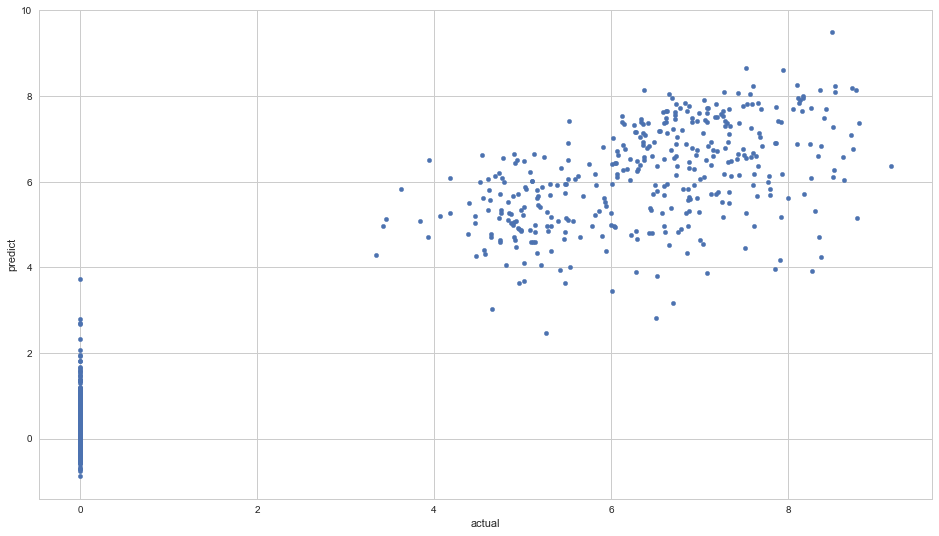

In [36]:
pd.DataFrame({'predict': CX_KI_WT_log_AB_predict_sgbm, 'actual': CX_KI_WT_log_AB_test}).plot.scatter(x='actual', y='predict', figsize=(16, 9))
plt.show()

## Some trial and error to find reasonable hyperparameters..

In [70]:
cv = ShuffleSplit(n_splits=10, test_size=0.15, random_state=42)

In [128]:
%%time
sgbm = GradientBoostingRegressor(learning_rate=0.005, n_estimators=10000, max_features=0.1, subsample=0.9, random_state=42)

scores = cross_val_score(sgbm,                          
                         X=CX_KI_WT_boruta, 
                         y=CX_KI_WT_log_AB, 
                         cv=cv, 
                         groups=CX_GT,                         
                         fit_params={'monitor': EarlyStopMonitor()},
                         scoring='neg_mean_squared_error',
                         n_jobs=-1)

stopped after rounds: 1513
stopped after rounds: 1585
stopped after rounds: 1571
stopped after rounds: 1598
stopped after rounds: 1586
stopped after rounds: 1602
stopped after rounds: 1675
stopped after rounds: 1678
stopped after rounds: 1713
stopped after rounds: 1719
CPU times: user 1.56 s, sys: 29 s, total: 30.6 s
Wall time: 1min 40s


In [129]:
scores

array([-0.88037112, -1.07514915, -0.89824702, -0.8955171 , -1.14378003,
       -1.02269046, -1.15769641, -0.94135984, -0.98878337, -0.86647303])

In [130]:
scores.mean()

-0.98700675415641936

---

# **Process explanations**

In [39]:
def vectorize(explanation, length):
    vector = np.zeros(length)
    
    for idx, value in explanation.as_map()[1]:
        vector[idx] = value
    
    return vector

In [40]:
def remove_0_cols(df):
    return df.loc[:, (df !=0).any(axis=0)]

In [41]:
def to_explanations(X_train,
                    X_explain,
                    model,
                    feature_names=boruta_genes,
                    n_features=50,
                    seed=42):
    
    explainer = LimeTabularExplainer(X_train,
                                     feature_names=feature_names,
                                     discretize_continuous=False,
                                     class_names=['log_AB'],
                                     mode='regression',
                                     feature_selection='lasso_path',
                                     random_state=seed,
                                     verbose=True)
        
    vec_explanations = []
    
    df = X_explain
    
    for idx in df.index:        
        e = explainer.explain_instance(df.loc[idx], model.predict, num_features=n_features)
        v = vectorize(e, df.shape[1])
            
        vec_explanations.append(v)
    
    explanations_df = pd.DataFrame(vec_explanations)    
    explanations_df.columns = feature_names
    explanations_df.index = df.index
    
    return explanations_df

In [42]:
def to_explanation_box_plots(explanations_df,
                             figsize=(30, 8)):
    
    mean_weights_df = pd.DataFrame(explanations_df.mean(axis=0)).reset_index()
    mean_weights_df.columns = ['gene', 'mean']
    mean_weights_df['abs_mean'] = mean_weights_df['mean'].abs()
    
    ordering = list(mean_weights_df.sort_values(by='abs_mean', ascending=False)['gene'])
    
    print(ordering)
    
    fig, ax = plt.subplots(figsize=figsize)
    plt.xticks(rotation=90)
    sns.boxplot(data=explanations_df.melt(), x='variable', y='value', ax=ax, order=ordering)
    plt.show()

In [ ]:
# %%time
# explanations_df = to_explanations(X_train=CX_KI_WT_boruta,
#                                   X_explain=CX_KI_WT_boruta,
#                                   model=model_sgbm_CX_KI_WT)

In [37]:
log_AB_explanations_path = '08_results/explanations_log_AB.tsv'

In [138]:
# explanations_df.to_csv(log_AB_explanations_path, sep='\t')

In [156]:
explanations_df = pd.read_csv(log_AB_explanations_path, sep='\t', index_col=0)

In [158]:
explanations_df.head()

,1500015O10Rik,2010107E04Rik,2410006H16Rik,2500004C02Rik,2610016A17Rik,2810433D01Rik,4833439L19Rik,4930426I24Rik,9330162G02Rik,AC149090.1,...,mt-Tl2,mt-Tm,mt-Tn,mt-Tp,mt-Tq,mt-Tr,mt-Ts2,mt-Tt,mt-Tv,mt-Tw
0,0.0,0.0,0.0,0.0,0.0,-0.032339,0.0,0.0,0.0,0.0,...,0.040573,0.086594,0.0,0.030194,0.0,0.0,0.000000,0.0,0.061303,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.046781,0.070733,0.0,0.027142,0.0,0.0,0.000000,0.0,0.049007,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.062650,0.082866,0.0,0.040212,0.0,0.0,0.020536,0.0,0.052536,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.036100,0.081599,0.0,0.031744,0.0,0.0,0.000000,0.0,0.043633,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.054598,0.076155,0.0,0.023694,0.0,0.0,0.000000,0.0,0.050597,0.0


['Cst7', 'Ctsd', 'Tyrobp', 'Gfap', 'Ccl21c.1', 'mt-Rnr1', 'B2m', 'Rplp1', 'Sez6', 'Trem2', 'Rpl12', 'C4b', 'mt-Rnr2', 'Cst3', 'Gm42418', 'Lyz2', 'Ctss', 'Ccl6', 'Cd68', 'Gm14303', 'Olfr912', 'Lrrc17', 'Fth1', 'Hexb', 'Gm28437', 'Gm6272', 'Clec7a', 'Gnas', 'C1qa', 'Cd74', 'Itgax', 'Rpl41', 'Bcl2a1d', 'Mamdc2', 'Ccl3', 'Bcl2a1b', 'Cd9', 'Lyz1', 'Cd180', 'Spp1', 'Hvcn1', 'Cxcl5', 'Cd14', 'Wfdc17', 'Mpeg1', 'H2-Aa', 'AU020206', 'Ly86', 'Apoe', 'Irf8', 'H2-Eb1', 'Ifi27l2a', 'C4a', 'Slc11a1', 'Slc6a3', 'H2-Ab1', 'C3ar1', 'Lag3', 'Cd300c2', 'Ctsb', 'Hcrt', 'Gm20631', 'Bst2', 'Fcer1g', 'Gpnmb', 'Gm15590', 'Purb', 'Cd53', 'Cd52', 'Gpr34', 'Plek', 'C1qc', 'Fcgr2b', 'Serpina3n', 'Anxa3', 'Fau', 'Gm7079', 'Psmb8', 'Olfml3', 'Erdr1', 'Rplp2', 'Lars2', 'Srgn', 'Malat1', 'Rpl38', 'Itgb5', 'Cox6a1', 'Rpl37', 'Psap', 'Rpl37a']


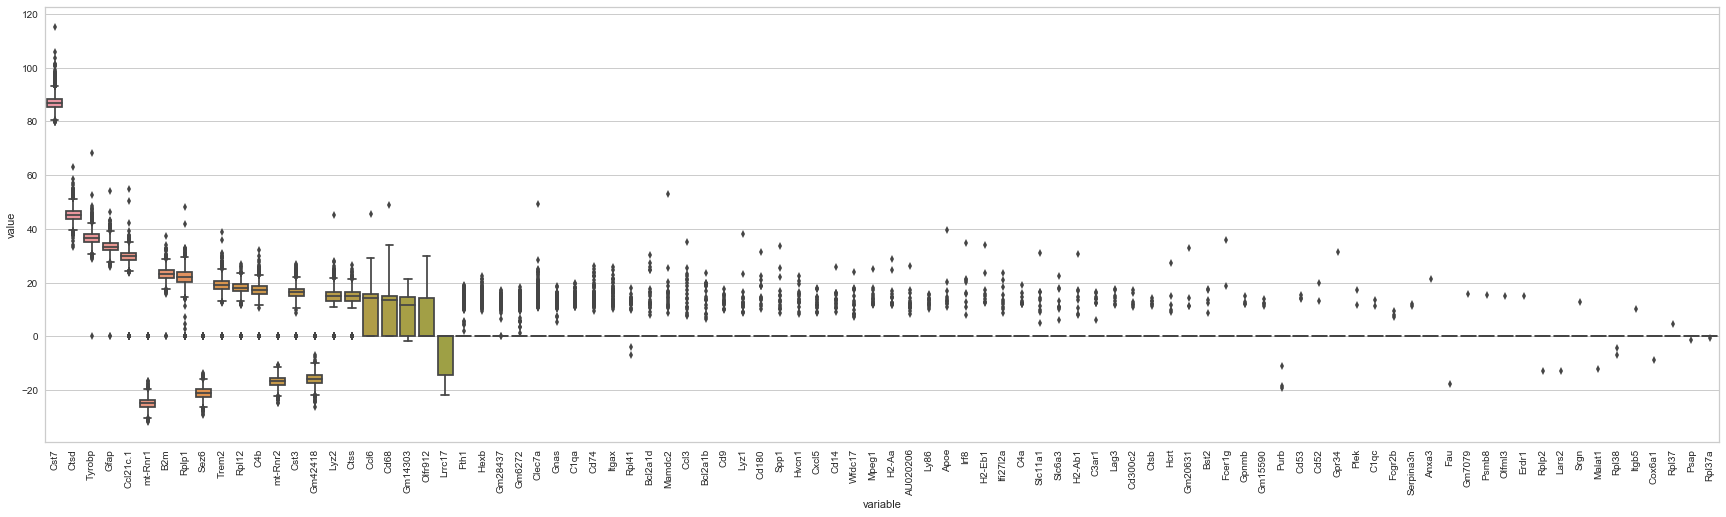

In [936]:
to_explanation_box_plots(clean_df)

In [645]:
slide_codes = list(KI_region_sets['CX']['slide_ID'].cat.codes)

* https://stackoverflow.com/questions/20978757/how-to-append-a-vector-to-a-matrix-in-python

In [613]:
len(explanations)

4101

# **Explanation space embedding**

Figure out if there is structure in the space of LIME explanations.

In [60]:
from sklearn.manifold import TSNE
from umap import UMAP

## **t-SNE**

In [81]:
%%time
tsne_embedding = TSNE(metric='correlation').fit_transform(pd.DataFrame(explanations_df))

CPU times: user 1min 34s, sys: 52 s, total: 2min 26s
Wall time: 2min 26s


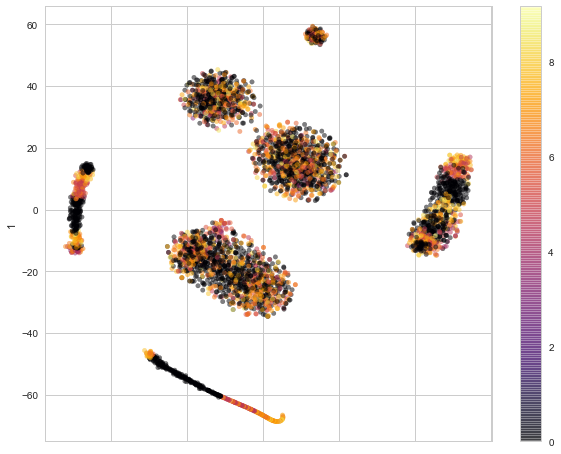

In [126]:
pd.DataFrame(tsne_embedding).plot.scatter(x=0, y=1, figsize=(10, 8), alpha=0.5, c=KI_WT_region_sets['CX']['log_AB'], cmap='inferno')
plt.show()

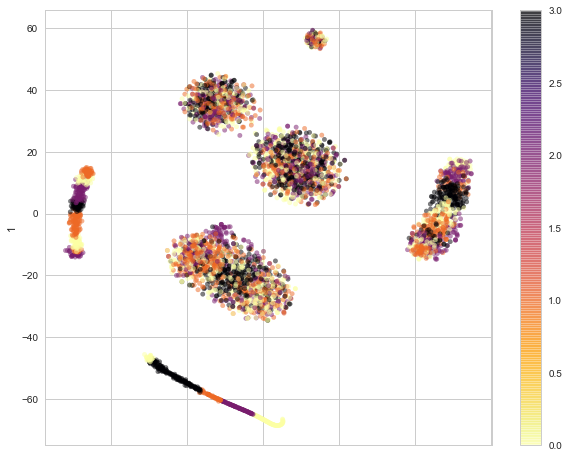

In [125]:
pd.DataFrame(tsne_embedding).plot.scatter(x=0, y=1, figsize=(10, 8), alpha=0.5, c=KI_WT_region_sets['CX']['age_GT'].cat.codes, cmap='inferno_r')
plt.show()

In [159]:
%%time
tsne_embedding_euclidean = TSNE(metric='euclidean', random_state=42).fit_transform(pd.DataFrame(explanations_df))

CPU times: user 2min 49s, sys: 53.9 s, total: 3min 43s
Wall time: 3min 43s


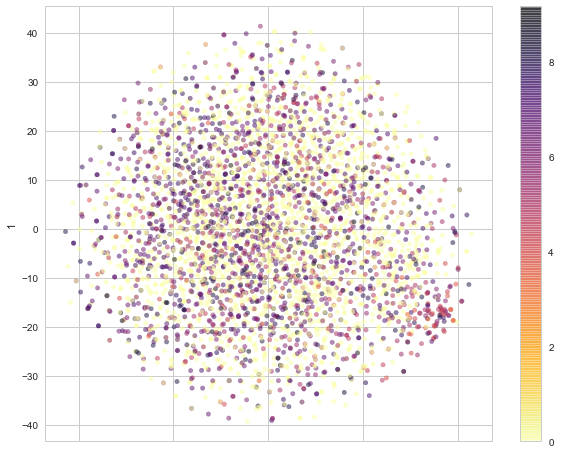

In [160]:
pd.DataFrame(tsne_embedding_euclidean).plot.scatter(x=0, y=1, figsize=(10, 8), alpha=0.5, c=KI_WT_region_sets['CX']['log_AB'], cmap='inferno_r')
plt.show()

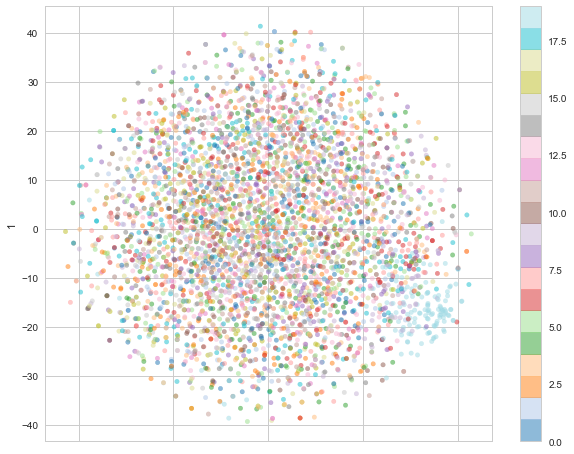

In [161]:
pd.DataFrame(tsne_embedding_euclidean).plot.scatter(x=0, y=1, figsize=(10, 8), alpha=0.5, c=KI_WT_region_sets['CX']['slide_ID'].cat.codes, cmap='tab20')
plt.show()

## **UMAP**

In [162]:
%%time
umap_embedding_cosine = UMAP(metric='cosine', random_state=13).fit_transform(pd.DataFrame(explanations_df))

CPU times: user 1min 13s, sys: 10.6 s, total: 1min 23s
Wall time: 1min 13s


In [163]:
%%time
umap_embedding_manhattan = UMAP(metric='manhattan', random_state=14).fit_transform(pd.DataFrame(explanations_df))

CPU times: user 1min 13s, sys: 10.3 s, total: 1min 24s
Wall time: 1min 13s


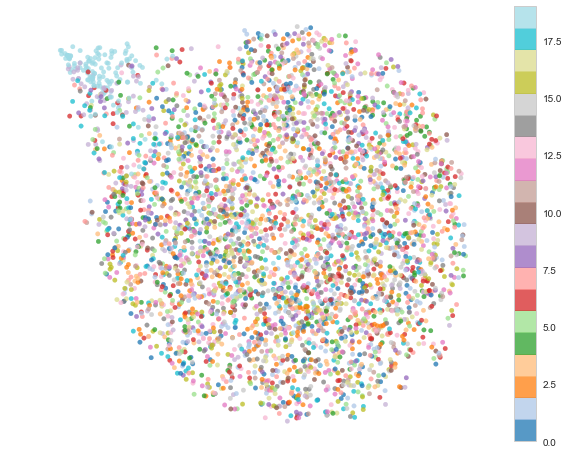

In [164]:
pd.DataFrame(umap_embedding_manhattan).plot.scatter(x=0, y=1, figsize=(10, 8), alpha=0.75, c=KI_WT_region_sets['CX']['slide_ID'].cat.codes, cmap='tab20')
plt.axis('off')
plt.grid(False)
plt.show()

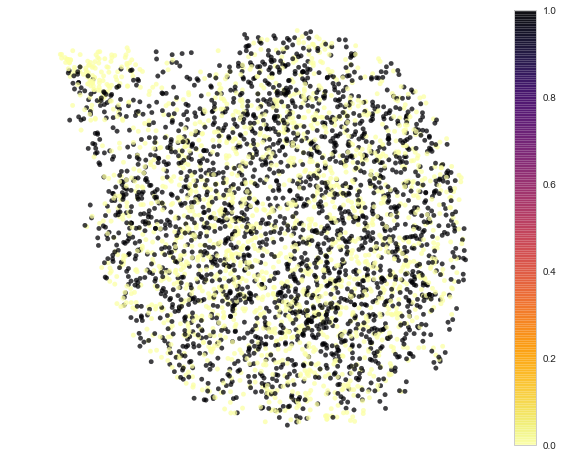

In [165]:
pd.DataFrame(umap_embedding_manhattan).plot.scatter(x=0, y=1, figsize=(10, 8), alpha=0.75, c=KI_WT_region_sets['CX']['GT'].cat.codes, cmap='inferno_r')
plt.axis('off')
plt.grid(False)
plt.show()

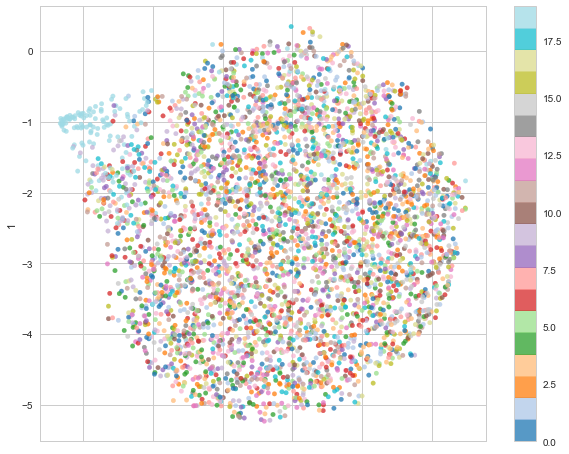

In [166]:
pd.DataFrame(umap_embedding_cosine).plot.scatter(x=0, y=1, figsize=(10, 8), alpha=0.75, c=KI_WT_region_sets['CX']['slide_ID'].cat.codes, cmap='tab20')
# plt.axis('off')
# plt.grid(False)
plt.show()

In [138]:
umap_cosine_df = pd.DataFrame(umap_embedding_cosine, columns=['x', 'y'])

In [151]:
group1 = (umap_cosine_df.x < -7) & (umap_cosine_df.y > 2.5) & (umap_cosine_df.y < 10)
group2 = (umap_cosine_df.x < -5) & (umap_cosine_df.y > 10) 

In [191]:
explanation_genes_df = \
    pd.DataFrame(explanations_df.mean(axis=0).abs(), columns=['abs_mean']) \
        .sort_values(by='abs_mean', ascending=False) \
        .head(70)
        
explanation_genes = list(explanation_genes_df.index)

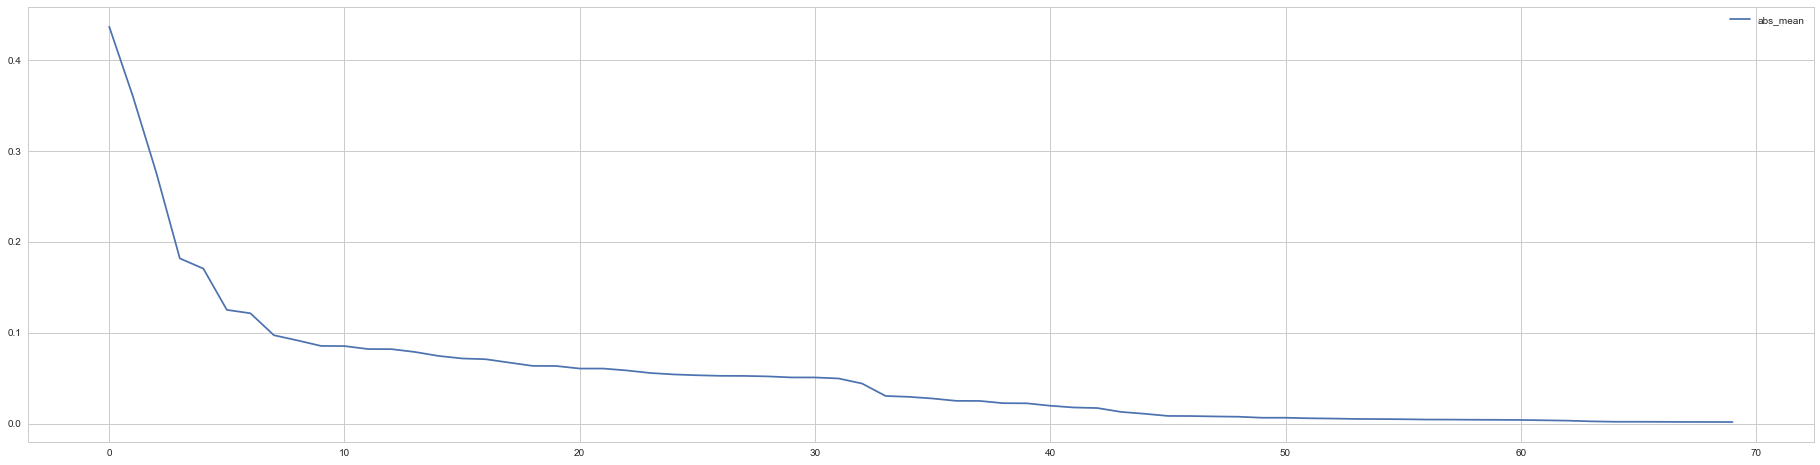

In [181]:
pd.DataFrame(explanations_df.mean(axis=0).abs(), columns=['abs_mean']) \
    .sort_values(by='abs_mean', ascending=False) \
    .head(70) \
    .plot(use_index=False, figsize=(32, 8))
    
plt.show()

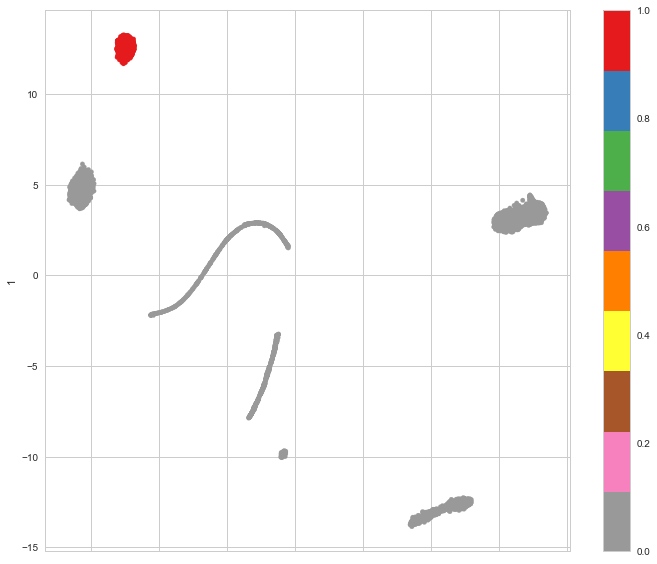

In [150]:
pd.DataFrame(umap_embedding_cosine).plot.scatter(x=0, y=1, figsize=(10, 8), c=group2, cmap='Set1_r')
# plt.axis('off')
# plt.grid(False)
plt.tight_layout()
plt.show()

---

# Embedding by the genes with highest explanation weight

In [248]:
explanation_genes[:12]

['Cst7',
 'Sez6',
 'Ccl21c.1',
 'Ctsd',
 'Gfap',
 'Tyrobp',
 'Rpl12',
 'Lrrc17',
 'mt-Rnr1',
 'mt-Rnr2',
 'Fth1',
 'Gm28437']

In [232]:
%%time
cx_umap_explanation_embedding = UMAP(spread=2.0).fit_transform(KI_WT_region_sets['CX'][explanation_genes[:12]])

CPU times: user 18.6 s, sys: 12.5 s, total: 31.1 s
Wall time: 17.2 s


In [236]:
%%time
cx_tsne_explanation_embedding = TSNE().fit_transform(KI_WT_region_sets['CX'][explanation_genes[:12]])

CPU times: user 1min 23s, sys: 50.7 s, total: 2min 13s
Wall time: 2min 13s


In [251]:
Cst7 = KI_WT_region_sets['CX']['Cst7']
Sez6 = KI_WT_region_sets['CX']['Sez6']

log_AB = KI_WT_region_sets['CX']['log_AB']
GT = KI_WT_region_sets['CX']['GT'].cat.codes
age = KI_WT_region_sets['CX']['age'].cat.codes
age_GT = KI_WT_region_sets['CX']['age_GT'].cat.codes
slide = KI_WT_region_sets['CX']['slide_ID'].cat.codes

In [228]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
#flatui = ["#34495e", "#2ecc71"]
my_cmap = ListedColormap(sns.color_palette(flatui[:4]).as_hex())

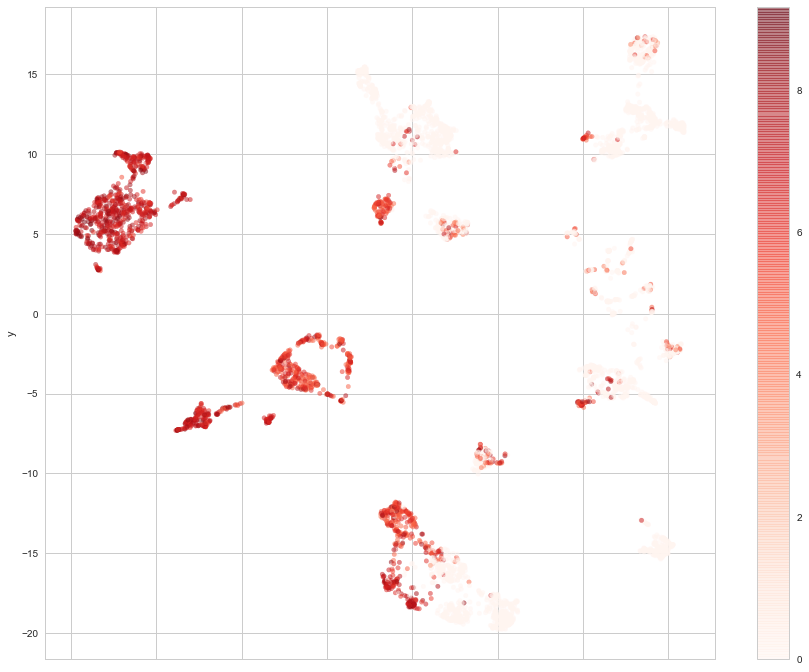

In [330]:
pd.DataFrame(cx_umap_explanation_embedding, columns=['x', 'y']).plot.scatter(x='x', y='y', c=log_AB, alpha=0.5, cmap='Reds', figsize=(15,12))
plt.show()

# Matrix of embedding colorings

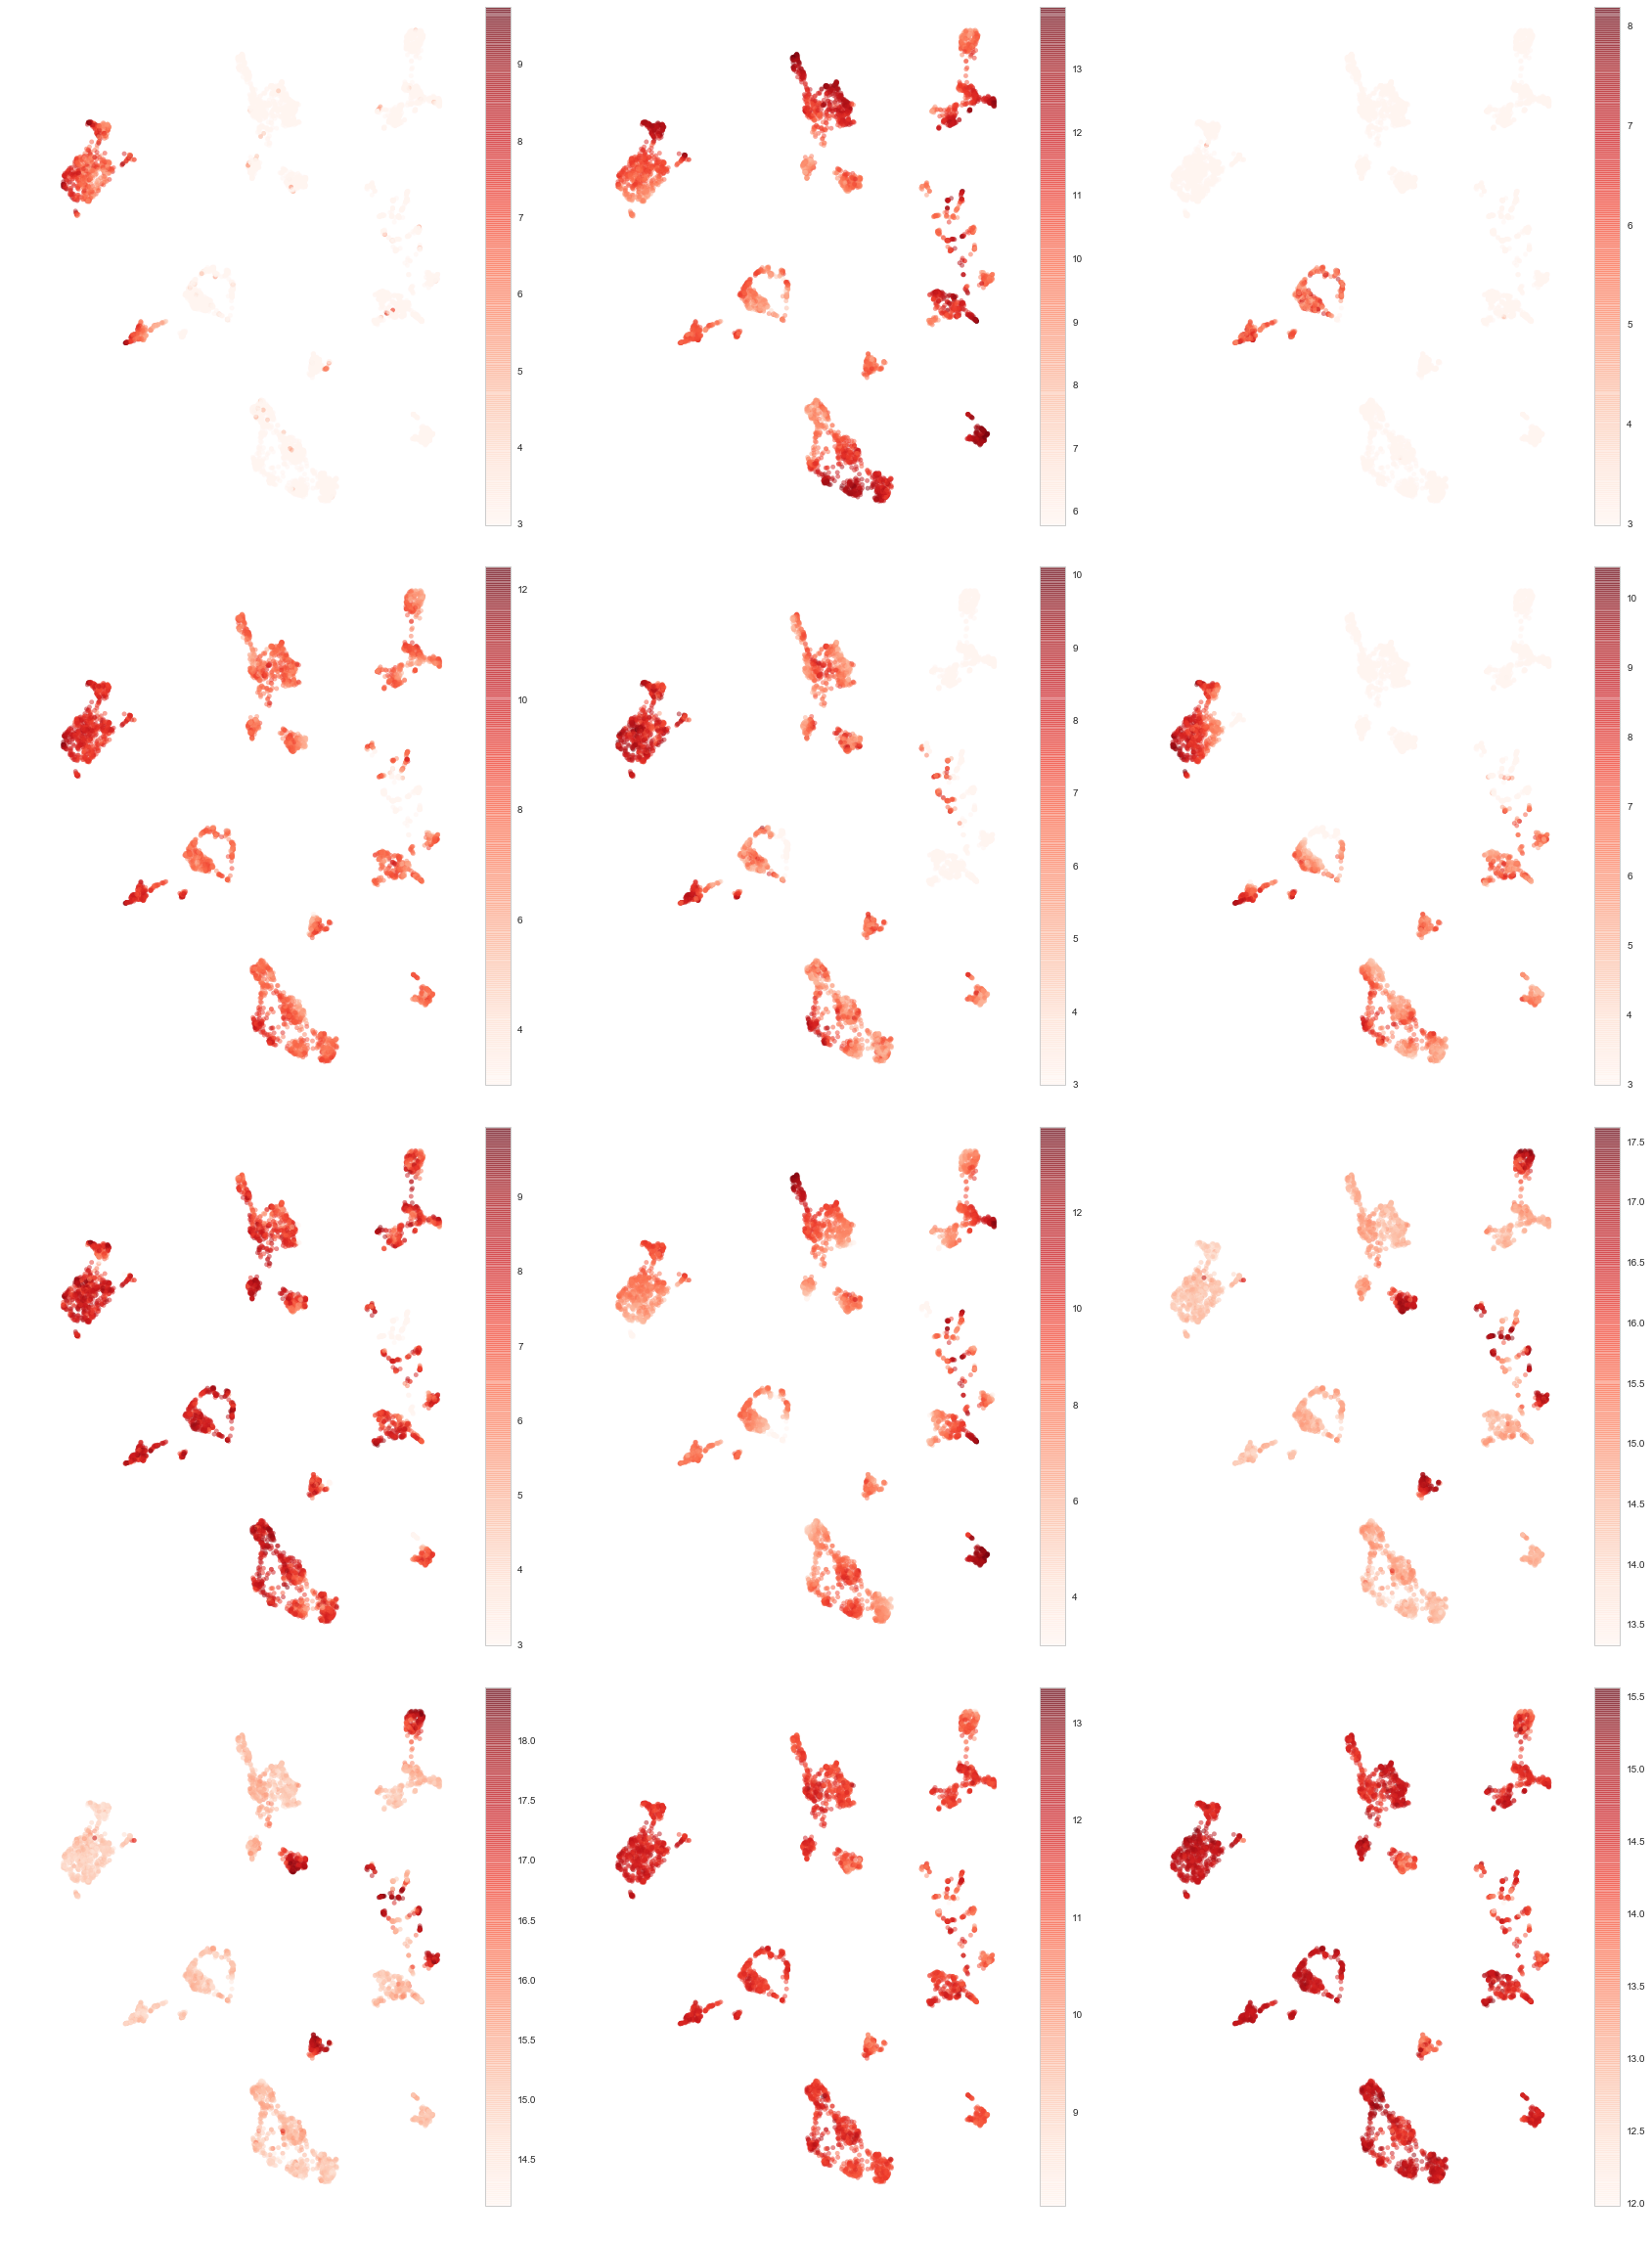

In [327]:
cx_df = pd.DataFrame(cx_umap_explanation_embedding, columns=['x', 'y'])

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(24,32))

for i, gene in enumerate(explanation_genes[:12]):
    ax = axes.flat[i]
    
    gene_coloring = KI_WT_region_sets['CX'][gene]
    
    g = cx_df.plot.scatter(x='x', y='y', ax=ax,
                           c=gene_coloring, cmap='Reds', alpha=0.5)
    
    g.axis('off')

#plt.axis('off')
plt.tight_layout()
plt.show()

matplotlib.axes._subplots.AxesSubplot

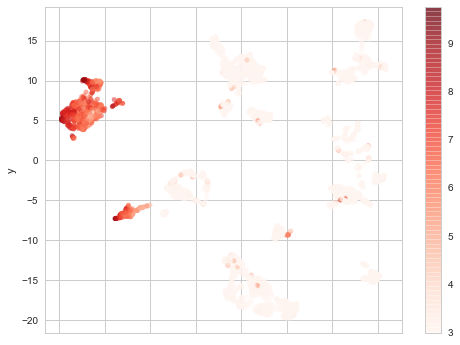

In [272]:
pd.DataFrame(cx_umap_explanation_embedding, columns=['x', 'y']).plot.scatter(x='x', y='y', c=Cst7, alpha=0.5, cmap='Reds', figsize=(8,6))
plt.show()

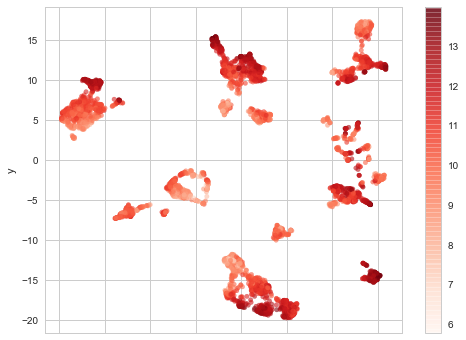

In [273]:
pd.DataFrame(cx_umap_explanation_embedding, columns=['x', 'y']).plot.scatter(x='x', y='y', c=Sez6, alpha=0.6, cmap='Reds', figsize=(8,6))
plt.show()

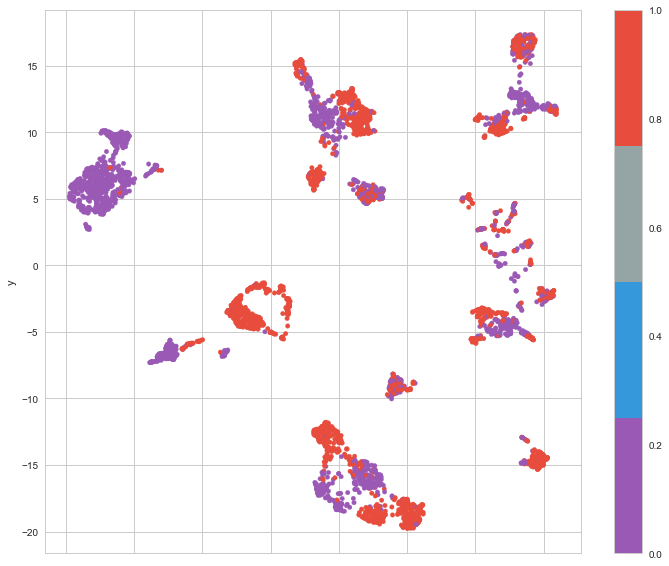

In [238]:
pd.DataFrame(cx_umap_explanation_embedding, columns=['x', 'y']).plot.scatter(x='x', y='y', c=age, cmap=my_cmap, figsize=(12,10))
plt.show()

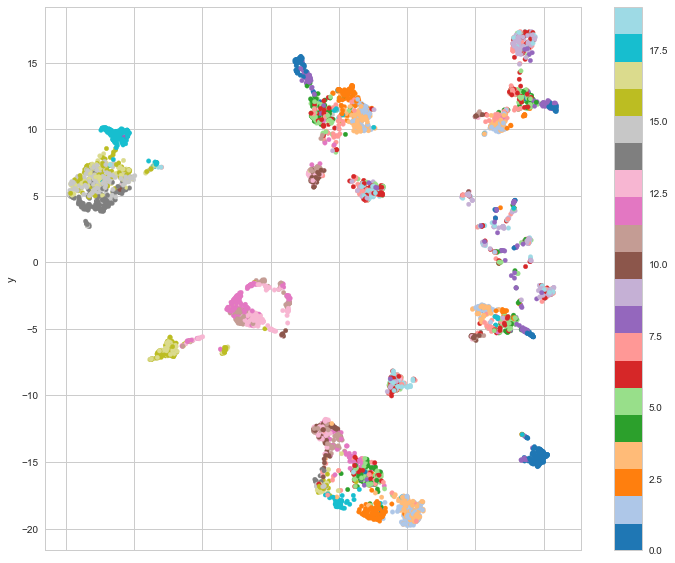

In [239]:
pd.DataFrame(cx_umap_explanation_embedding, columns=['x', 'y']).plot.scatter(x='x', y='y', c=slide, cmap='tab20', figsize=(12,10))
plt.show()

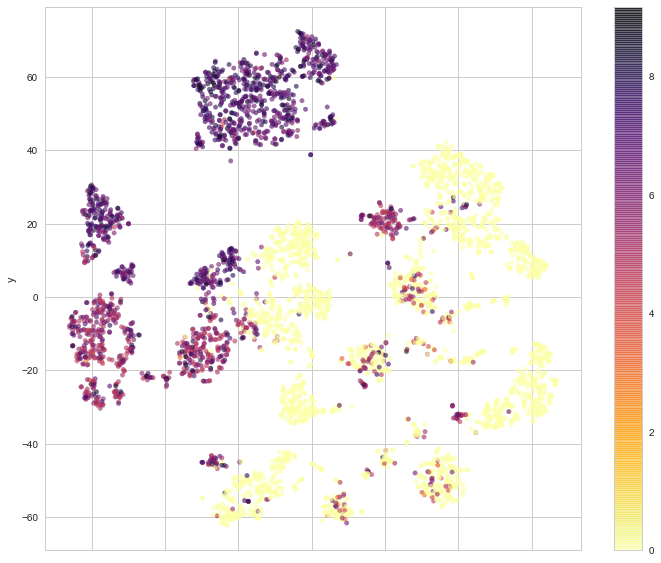

In [240]:
pd.DataFrame(cx_tsne_explanation_embedding, columns=['x', 'y']).plot.scatter(x='x', y='y', c=log_AB, alpha=0.6, cmap='inferno_r', figsize=(12,10))
plt.show()

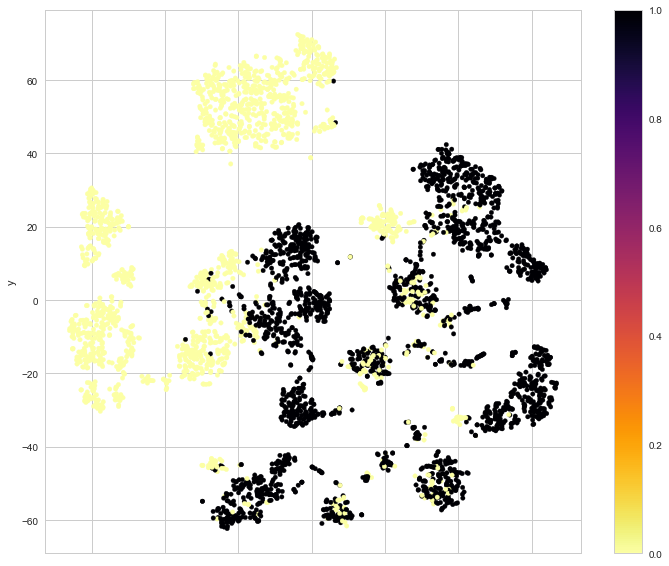

In [246]:
pd.DataFrame(cx_tsne_explanation_embedding, columns=['x', 'y']).plot.scatter(x='x', y='y', c=GT, cmap='inferno_r', figsize=(12,10))
plt.show()

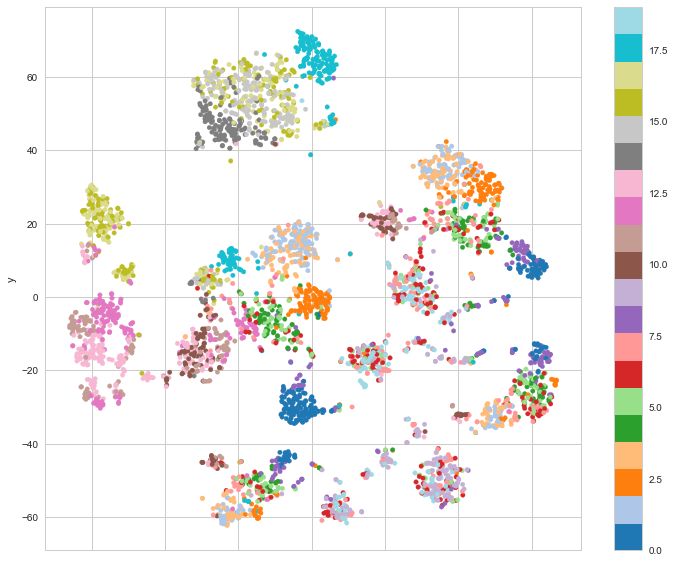

In [242]:
pd.DataFrame(cx_tsne_explanation_embedding, columns=['x', 'y']).plot.scatter(x='x', y='y', c=slide, cmap='tab20', figsize=(12,10))
plt.show()